In [9]:
!pip install tensorflow
!pip install keras-tuner
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [42]:
import os
import zipfile
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- UNZIP DATASET (If using google collaab) ---
dataset_zip = '/content/data_final.zip'
if not os.path.exists('/content/data_final'):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/data_final')

# --- PARAMETERS ---
IMG_SIZE = (224, 224)
CLASSES = [chr(i) for i in range(ord('A'), ord('Z')+1)]

# --- UTILITY: LOAD & CROP DATA ---
def load_dataset(image_dir):
    images, labels = [], []
    i = 0
    for img_path in glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True):
        i+=1
        xml_path = os.path.splitext(img_path)[0] + '.xml'
        if not os.path.exists(xml_path):
            continue
        try:
            tree = ET.parse(xml_path)
            obj = tree.find('.//object')
            label = obj.find('name').text.strip().upper()
            if label not in CLASSES:
                continue
            b = obj.find('bndbox')
            xmin, ymin = int(b.find('xmin').text), int(b.find('ymin').text)
            xmax, ymax = int(b.find('xmax').text), int(b.find('ymax').text)
        except Exception:
            continue
        img = Image.open(img_path).convert('RGB').crop((xmin, ymin, xmax, ymax)).resize(IMG_SIZE)
        if (i < 20):
            img.save(f"/content/cropped_sample{i}.jpg")


        arr = np.array(img)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        images.append(arr)
        labels.append(CLASSES.index(label))
    X = np.expand_dims(np.array(images), axis=1)
    y = to_categorical(labels, num_classes=len(CLASSES))
    return X, y

# Load & split
dir_path = '/content/data_final/data'
X, y = load_dataset(dir_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Compute class weights
y_indices = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight('balanced', classes=np.arange(len(CLASSES)), y=y_indices)
class_weights = dict(enumerate(weights))

# --- MODEL BUILDING ---
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow_model_optimization.sparsity import keras as sparsity
from keras_tuner import RandomSearch
import tensorflow_model_optimization as tfmot


def build_model(hp):
    l2_val = hp.Choice('l2_reg', [1e-4, 1e-5])
    learning_rate = hp.Choice('lr', [1e-3, 1e-4, 1e-5])


    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
    mobilenet.trainable = False

    inp = Input((1,224,224,3))
    x = TimeDistributed(mobilenet)(inp)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = LSTM(64, kernel_regularizer=l2(l2_val), recurrent_regularizer=l2(l2_val))(x)
    x = Dropout(0.6)(x)

    out = Dense(len(CLASSES), activation='softmax', kernel_regularizer=l2(l2_val))(x)

    model = Model(inp, out)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- TUNING ---
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='random_search',
    project_name='mobilenetv2_lstm'
)

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=4)
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hp)

model.summary()


# --- TRAIN HEAD ---
checkpoint_head = ModelCheckpoint('best_head.h5', save_best_only=True, monitor='val_accuracy')
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[checkpoint_head, early_stop]
)

# --- FINE-TUNE LAST BLOCKS ---
mobilenet = model.get_layer(index=1).layer
for layer in mobilenet.layers:
    if any(block in layer.name for block in ['block_13', 'block_14', 'block_15']):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_ft = ModelCheckpoint('best_finetune.h5', save_best_only=True, monitor='val_accuracy')
early_stop2 = EarlyStopping(patience=20, restore_best_weights=True)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, early_stop2]
)

model.save('/content/model_refined_b0.h5')
print("Training complete. Model saved as MobileNetV2-based.")

pruning_schedule = sparsity.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000, 
    frequency=100
)

import tensorflow as tf

# --- Representative dataset generator ---
def representative_data_gen():
    for i in range(100): 
        yield [X_train[i:i+1].astype("float32")]

# --- Converter with fallback for LSTM ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Enable fallback to TF ops for LSTM compatibility
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Convert and save
tflite_quant_model = converter.convert()
with open("/content/model_refined_b0_ptq.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ PTQ model saved as model_refined_b0_ptq.tflite")

Reloading Tuner from random_search/mobilenetv2_lstm/tuner0.json


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 1, 224, 224, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 1, 7, 7, 1280)  │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 1, 1280)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,994 (9.93 MB)

 Trainable params: 346,010 (1.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0917 - loss: 3.2534

18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.0922 - loss: 3.2509 - val_accuracy: 0.2949 - val_loss: 2.9415
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2526 - loss: 2.8485

18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2551 - loss: 2.8431 - val_accuracy: 0.6026 - val_loss: 2.3659
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3920 - loss: 2.3748

18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3945 - loss: 2.3690 - val_accuracy: 0.7179 - val_loss: 1.9012
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5984 - loss: 1.8862

18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5989 - loss: 1.8828 - val_accuracy: 0.8291 - val_loss: 1.5181
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7334 - loss: 1.5143

18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7341 - loss: 1.5102 - val_accuracy: 0.8761 - val_loss: 1.2148
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8001 - loss: 1.2365 - val_accuracy: 0.8718 - val_loss: 1.0024
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8823 - loss: 1.0180

18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8823 - loss: 1.0162 - val_accuracy: 0.8974 - val_loss: 0.8646
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8888 - loss: 0.8349

18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8887 - loss: 0.8342 - val_accuracy: 0.9402 - val_loss: 0.7358
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9303 - loss: 0.6953 - val_accuracy: 0.9359 - val_loss: 0.6568
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9478 - loss: 0.6557

18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9472 - loss: 0.6546 - val_accuracy: 0.9615 - val_loss: 0.5931
Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.3957 - loss: 2.1334

35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3975 - loss: 2.1289 - val_accuracy: 0.9573 - val_loss: 0.5834
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5528 - loss: 1.7885 - val_accuracy: 0.9530 - val_loss: 0.5836
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6472 - loss: 1.4659 - val_accuracy: 0.9573 - val_loss: 0.5859
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6870 - loss: 1.3169 - val_accuracy: 0.9359 - val_loss: 0.5898
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7568 - loss: 1.1583 - val_accuracy: 0.9402 - val_loss: 0.5933
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7741 - loss: 1.1439 - val_accuracy: 0.9402 - val_loss: 0.5881
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8212 - loss: 0.9985 - val_accuracy: 0.9402 - val_loss: 0.5854
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8455 - loss: 0.9350 - val_accuracy: 0.9402 - val_loss: 0.5816
Epo

Training complete. Model saved as MobileNetV2-based.
Saved artifact at '/tmp/tmpfhkh2xao'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 224, 224, 3), dtype=tf.float32, name='keras_tensor_4182')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  134278715943312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715944848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715944464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715945232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715942736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715945616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715946000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715946384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715946192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134278715943504: Tenso

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ PTQ model saved as model_refined_b0_ptq.tflite


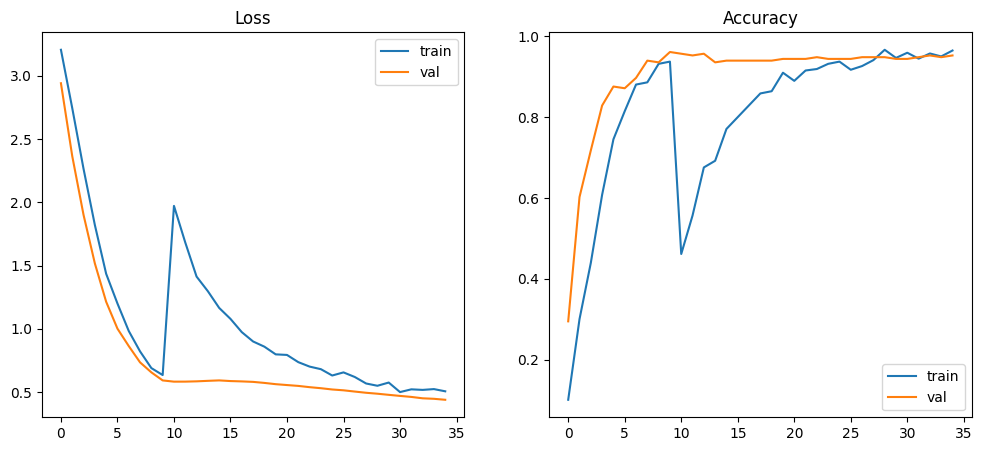

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'] + history2.history['loss'], label='train')
plt.plot(history1.history['val_loss'] + history2.history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend()
plt.savefig('training_curves.png')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


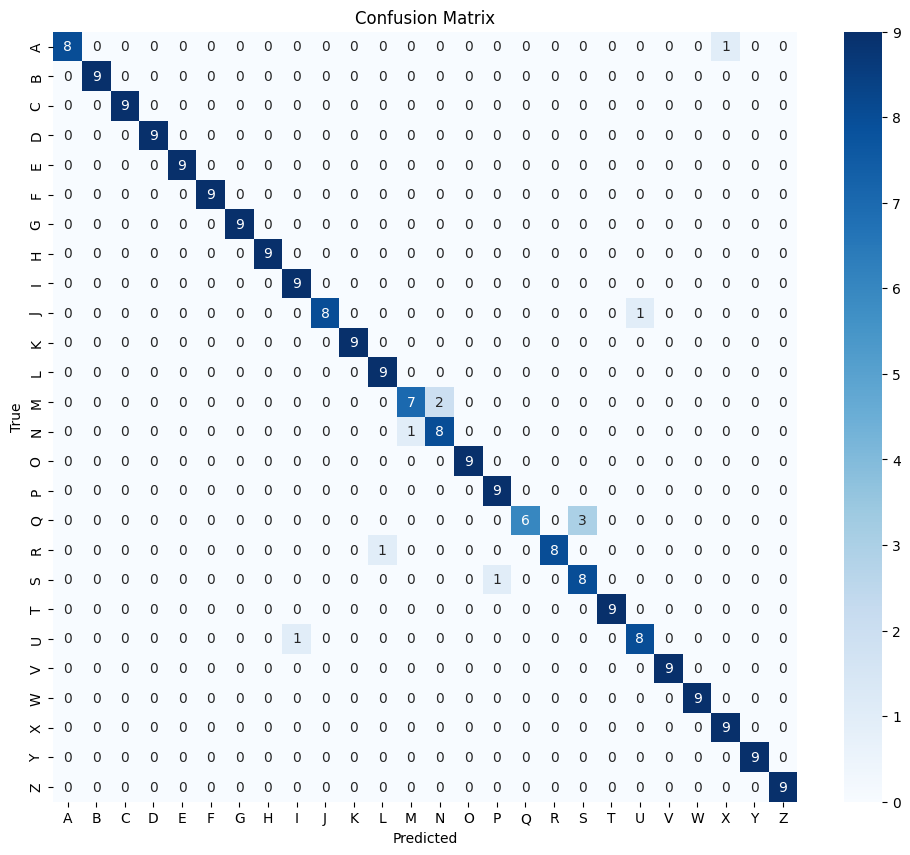

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Predict on validation set ---
y_val_true = np.argmax(y_val, axis=1)  # convert one-hot to class indices
y_val_pred = model.predict(X_val)
y_val_pred_idx = np.argmax(y_val_pred, axis=1)

# --- Compute confusion matrix ---
cm = confusion_matrix(y_val_true, y_val_pred_idx)

# --- Plot confusion matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true and predicted class indices
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Build confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Print per-class accuracy
for idx, acc in enumerate(per_class_acc):
    print(f"Class {CLASSES[idx]}: {acc:.2%} accuracy")


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Class A: 88.89% accuracy
Class B: 100.00% accuracy
Class C: 100.00% accuracy
Class D: 100.00% accuracy
Class E: 100.00% accuracy
Class F: 100.00% accuracy
Class G: 100.00% accuracy
Class H: 100.00% accuracy
Class I: 100.00% accuracy
Class J: 88.89% accuracy
Class K: 100.00% accuracy
Class L: 100.00% accuracy
Class M: 77.78% accuracy
Class N: 88.89% accuracy
Class O: 100.00% accuracy
Class P: 100.00% accuracy
Class Q: 66.67% accuracy
Class R: 88.89% accuracy
Class S: 88.89% accuracy
Class T: 100.00% accuracy
Class U: 88.89% accuracy
Class V: 100.00% accuracy
Class W: 100.00% accuracy
Class X: 100.00% accuracy
Class Y: 100.00% accuracy
Class Z: 100.00% accuracy


In [47]:
!pip install pydot


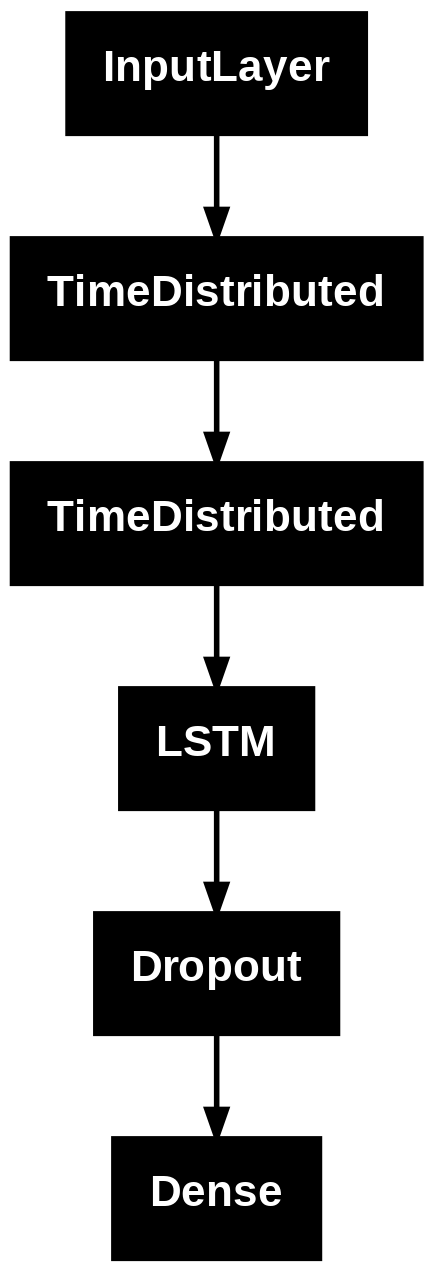

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",  # Top-Bottom
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False
)